In [7]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW
import os
import cv2
import random
import optuna
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate, Multiply)

# === Initial Configuration ===
config = {
    "epochs": 1,
    "is_config_batch_size_param": True,
    "batch_size": 200,
    "initial_lr": 0.001,
    "gpu_memory_limit": 45,
    "target_size": (480, 640), 
    "input_shape": (640, 480, 3),
    "data_path": "Dataset/merged_SMOT_train",
    "csv_path": "processed_data/cleaned_metadata_short.csv",
    "train_set_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_train_set.csv",
    "val_set_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_validation_set.csv",
    "history_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_history.csv",
    "best_model": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_best_model.keras",
    "label_encoder_path": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_label_encoder.npy",
    "color_channel": "",
    "save_dir": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1",
    "n_trials": 2,
}

2025-05-14 23:37:32.957652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 23:37:32.958267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:37:32.960834: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:37:32.967716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747240652.978972  347862 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747240652.98

In [8]:
#*** Model Save is disanbled for testing purposes ***
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

In [ ]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

2025-05-14 23:37:34.959403: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


In [ ]:
class RiceDataGenerator(Sequence):
    """ Generator for loading and augmenting rice images """
    def __init__(self, df, base_path, batch_size=32, target_size=(480, 640), shuffle=False, debug=False, config=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        self.config = config if config else {}
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            
    # Visualize original and augmented images
    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]


In [12]:
# === Model Architecture ===
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    return Multiply()([input_tensor, se])

def create_customCNN(input_shape, num_classes, conv_filters=96):    
    inputs = Input(shape=input_shape, dtype=tf.float32) 
     
    # Initial feature extraction
    x = Conv2D(conv_filters, (7,7), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    x = se_block(x)

    # Intermediate layers
    x = Conv2D(256, (5,5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Parallel paths
    branch1 = Conv2D(384, (3,3), activation='relu', padding='same')(x)
    branch2 = Conv2D(384, (3,3), dilation_rate=2, activation='relu', padding='same')(x)
    x = Concatenate()([branch1, branch2])
        
    # Final classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='features')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# === Optimization ===
def train_for_optimization(config, trial):
    cleanup_gpu_memory()
    train_df, val_df, le = load_and_preprocess_data()
    
    model = create_customCNN(
        config["input_shape"], 
        len(le.classes_),
        conv_filters=config.get("conv_filters", 96)
    )
    
    train_gen = RiceDataGenerator(
        train_df, config["data_path"], 
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    val_gen = RiceDataGenerator(
        val_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    model.compile(
        optimizer=AdamW(learning_rate=config["initial_lr"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config["epochs"],  
        callbacks=[
            TFKerasPruningCallback(trial, "val_accuracy"),
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ],
        verbose=0
    )
    
    return max(history.history['val_accuracy'])

# === Optimized Objective Function ===
def objective(trial, config):
    params = {
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.2, 0.8),
        "conv_filters": trial.suggest_int("conv_filters", 32, 256, step=32),
        "use_batchnorm": trial.suggest_categorical("use_batchnorm", [True, False]),
        "optimizer": trial.suggest_categorical("optimizer", ["adamw", "sgd", "rmsprop"])
    }
    
    current_config = config.copy()
    current_config.update(params)
    
    return train_for_optimization(current_config, trial)



In [15]:
def optimize_hyperparameters(config, n_trials=30):
    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    )
    
    study.optimize(lambda trial: objective(trial, config), n_trials=n_trials)
    
    # Visualization
    fig = plot_optimization_history(study)
    fig.show()
    fig = plot_param_importances(study)
    fig.show()
    
    return study.best_params


In [ ]:
# === Final Training Function ===
def train_final_model(config):
    cleanup_gpu_memory()
    train_df, val_df, le = load_and_preprocess_data()
    
    model = create_customCNN(
        config["input_shape"],
        len(le.classes_),
        conv_filters=config.get("conv_filters", 96)
    )
    
    train_gen = RiceDataGenerator(
        train_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    val_gen = RiceDataGenerator(
        val_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    model.compile(
        optimizer=AdamW(learning_rate=config["initial_lr"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config["epochs"],
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                config["best_model"],
                save_best_only=True,
                monitor='val_accuracy'
            )
        ]
    )
    
    return model, history


In [ ]:
def plot_accuracy_loss(history):
    """Plot accuracy and loss"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

[I 2025-05-14 23:37:35,082] A new study created in memory with name: no-name-5b4bc6ef-b430-4b65-8c08-64d6df75eeec


Starting hyperparameter optimization...
Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 23:37:48,176] Trial 0 finished with value: 0.25 and parameters: {'lr': 0.00018824979820006936, 'batch_size': 32, 'dropout_rate': 0.6762478362337954, 'conv_filters': 64}. Best is trial 0 with value: 0.25.


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 23:38:00,757] Trial 1 finished with value: 0.375 and parameters: {'lr': 0.0004297832897098259, 'batch_size': 64, 'dropout_rate': 0.38586038760896363, 'conv_filters': 128}. Best is trial 1 with value: 0.375.


Best parameters: {'lr': 0.0004297832897098259, 'batch_size': 64, 'dropout_rate': 0.38586038760896363, 'conv_filters': 128}
Starting final training...
Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


/tmp/ipykernel_347862/855029412.py:26: UserWarning:

Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout



Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2500 - loss: 2.1854WARNING:tensorflow:5 out of the last 21 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7f8964ab37e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2500 - loss: 2.1854 - val_accuracy: 0.2500 - val_loss: 1.9113
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2857 - loss: 5.2541 - val_accuracy: 0

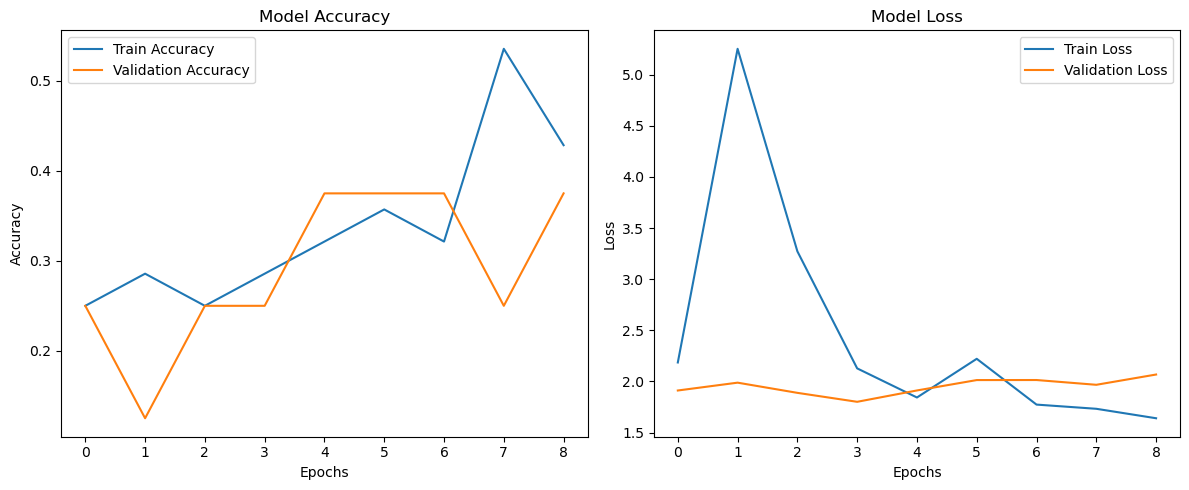

Training completed and model saved!


In [ ]:
os.makedirs(config["save_dir"], exist_ok=True)

opt_config = {
    **config,
    "target_size": (255, 255),
    "input_shape": (255, 255, 3)
}

# Run optimization
print("Starting hyperparameter optimization...")
best_params = optimize_hyperparameters(opt_config, n_trials=config["n_trials"])
print("Best parameters:", best_params)

# Run training
final_config = {
    **opt_config,
    **best_params,
    "epochs": 50,
    "augmentation": [
        A.Resize(width=255, height=255),
        A.HueSaturationValue(p=0.5),
        A.CLAHE(p=0.5),    
        A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=1, max_width=1),
    ]
}

print("Starting final training...")
final_model, final_history = train_final_model(final_config)

plot_accuracy_loss(final_history)

# Save again for safety
final_model.save(os.path.join(config["save_dir"], 'final_model.keras'))
with open(os.path.join(config["save_dir"], 'training_history.pkl'), 'wb') as f:
    pickle.dump(final_history.history, f)

print("Training completed and model saved!")

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
def plot_class_accuracy(y_true, y_pred, classes):
    correct = (y_true == y_pred)
    class_acc = []
    for i in range(len(classes)):
        idx = np.where(y_true == i)[0]
        acc = np.mean(correct[idx]) if len(idx) > 0 else 0
        class_acc.append(acc)
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # Bar plot for class distribution
    ax1.bar(classes, [np.sum(y_true == i) for i in range(len(classes))], 
            color='skyblue', alpha=0.7, label='Samples')
    ax1.set_ylabel('Number of Samples', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    
    # Line plot for accuracy
    ax2 = ax1.twinx()
    ax2.plot(classes, class_acc, 'r-o', linewidth=2, markersize=8, 
             label='Accuracy')
    ax2.set_ylabel('Accuracy', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1.1)
    
    plt.title('Class Distribution vs. Accuracy')
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(model, eval_gen, classes):
    all_probs = []
    all_labels = []
    
    for i in range(len(eval_gen)):
        x, y = eval_gen[i]
        probs = model.predict(x, verbose=0)
        all_probs.extend(probs.max(axis=1))
        all_labels.extend(y)
    
    plt.figure(figsize=(10,6))
    for class_id in range(len(classes)):
        class_probs = [p for p, l in zip(all_probs, all_labels) if l == class_id]
        sns.kdeplot(class_probs, label=classes[class_id], fill=True)
    
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_error_types(y_true, y_pred, classes):
    error_mask = (y_true != y_pred)
    fp_counts = []
    fn_counts = []
    
    for i in range(len(classes)):
        # False positives (predicted as i but actually not)
        fp = np.sum((y_pred == i) & (y_true != i))
        # False negatives (actually i but predicted as not i)
        fn = np.sum((y_true == i) & (y_pred != i))
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width/2, fp_counts, width, label='False Positives', color='salmon')
    ax.bar(x + width/2, fn_counts, width, label='False Negatives', color='lightblue')
    
    ax.set_ylabel('Count')
    ax.set_title('False Positives vs False Negatives per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_topk_accuracy(y_true, y_probs, classes, k=3):
    topk_correct = np.zeros(k)
    
    for i in range(1, k+1):
        topk_pred = np.argsort(y_probs, axis=1)[:, -i:]
        topk_correct[i-1] = np.mean([y_true[j] in topk_pred[j] for j in range(len(y_true))])
    
    plt.figure(figsize=(8,5))
    plt.bar(range(1,k+1), topk_correct, color='teal')
    plt.xticks(range(1,k+1))
    plt.xlabel('Top-K')
    plt.ylabel('Accuracy')
    plt.title(f'Top-K Classification Accuracy (K=1 to {k})')
    plt.ylim(0, 1.1)
    
    for i, acc in enumerate(topk_correct):
        plt.text(i+1, acc+0.02, f"{acc:.2%}", ha='center')
    
    plt.show()
    
def plot_feature_space(model, eval_gen, classes, n_samples=1000):
    # Get feature extractor (remove last layer)
    feature_model = tf.keras.Model(inputs=model.inputs, 
                                 outputs=model.layers[-2].output)
    
    # Get features and labels
    features, labels = [], []
    for i in range(min(10, len(eval_gen))):  # Limit batches for memory
        x, y = eval_gen[i]
        features.extend(feature_model.predict(x, verbose=0))
        labels.extend(y)
    
    # Downsample if too many points
    if len(features) > n_samples:
        idx = np.random.choice(len(features), n_samples, replace=False)
        features = np.array(features)[idx]
        labels = np.array(labels)[idx]
    else:
        features = np.array(features)
        labels = np.array(labels)
    
    # Reduce dimensionality
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(12,8))
    scatter = plt.scatter(features_2d[:,0], features_2d[:,1], 
                         c=labels, cmap='tab20', alpha=0.6)
    
    plt.title('t-SNE Visualization of Feature Space')
    plt.legend(handles=scatter.legend_elements()[0], 
               labels=list(classes),
               bbox_to_anchor=(1.05, 1), 
               loc='upper left')
    plt.tight_layout()
    plt.show()

def evaluate_saved_model(use_val_set=True, config=None):
    # Validate config
    if not config:
        raise ValueError("Configuration dictionary must be provided")
        
    with open(config['label_encoder_path'], 'rb') as f:
        le = LabelEncoder()
        le.classes_ = np.load(f, allow_pickle=True)
    
    cleanup_gpu_memory()
    model = tf.keras.models.load_model(config["best_model"], compile=False)
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
        ]
    )
    
    eval_df = (pd.read_csv(config["val_set_csv"]) 
                if use_val_set 
                else load_and_preprocess_data(save_splits=False)[1])
    print(f"\nEvaluating on {len(eval_df)} samples (batch size: {config['batch_size']})")
    
    eval_gen = RiceDataGenerator(
        df=eval_df,
        base_path=config["data_path"],
        batch_size=config['batch_size'],
        target_size=config["target_size"],
        shuffle=False,
        debug=False,
        config=config
    )
    
    # ======================
    # 4. Debug Checks
    # ======================
    # Inspect first batch
    x_test, y_test = eval_gen[0]
    print("\n[DEBUG] First batch inspection:")
    print(f"- Input shape: {x_test.shape}")
    print(f"- Label shape: {y_test.shape}")
    print(f"- Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")
    
    # ======================
    # 5. Model Evaluation
    # ======================
    print("\n=== Running Evaluation ===")
    results = model.evaluate(eval_gen, verbose=1, return_dict=True)
    print("\n[METRICS] Evaluation Results:", results)
    
    # ======================
    # 6. Prediction Analysis
    # ======================
    y_true, y_pred = [], []
    for i in range(len(eval_gen)):
        x, y = eval_gen[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Validation check
    if len(y_true) != len(y_pred):
        raise ValueError(f"Label/prediction length mismatch! {len(y_true)} vs {len(y_pred)}")
    
    # Print samples
    print("\n[PREDICTION SAMPLES] (True vs Predicted)")
    sample_indices = np.random.choice(len(y_true), size=min(5, len(y_true)), replace=False)
    for idx in sample_indices:
        print(f"{le.classes_[y_true[idx]]} → {le.classes_[y_pred[idx]]} "
                f"(Correct: {y_true[idx] == y_pred[idx]})")
    
    # ======================
    # 7. Advanced Metrics
    # ======================
    print("\n=== Detailed Metrics ===")
    
    # Confusion Matrix Info
    print(f"\nClasses: {list(le.classes_)}")
    print(f"Total evaluated samples: {len(y_true)}")
    
    # Plot confusion matrices
    for normalize in [True, False]:
        plot_confusion_matrix(
            y_true,
            y_pred,
            classes=le.classes_,
            normalize=normalize,
            title=f"Confusion Matrix ({'Normalized' if normalize else 'Counts'})"
        )
        
    plot_class_accuracy(y_true, y_pred, le.classes_)  
    
    plot_confidence_distribution(model, eval_gen, le.classes_)  
    
    plot_error_types(y_true, y_pred, le.classes_)
    
    # Classification report
    from sklearn.metrics import classification_report
    print("\n[CLASSIFICATION REPORT]")
    print(classification_report(
        y_true,
        y_pred,
        target_names=le.classes_,
        digits=4
    ))
    
    return results
        

In [ ]:
results = evaluate_saved_model("Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/final_model.keras", use_val_set=True, input_config=final_config)

# Access specific results:
print("Test Accuracy:", results['metrics']['accuracy'])
print("Class-wise Performance:")
print(pd.DataFrame(results['classification_report']).transpose())

{'epochs': 50, 'is_config_batch_size_param': True, 'batch_size': 64, 'initial_lr': 0.001, 'gpu_memory_limit': 45, 'target_size': (255, 255), 'input_shape': (255, 255, 3), 'data_path': 'Dataset/merged_SMOT_train', 'csv_path': 'processed_data/cleaned_metadata_short.csv', 'train_set_csv': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_train_set.csv', 'val_set_csv': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_validation_set.csv', 'history_csv': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_history.csv', 'best_model': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_best_model.keras', 'label_encoder_path': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_label_encoder.npy', 'color_channel': '', 'save_dir': 'Model/training8_customCNN_rgb_att_SMOT_aug_bay_1', 'n_tria

InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/derrickle/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/derrickle/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/derrickle/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_347862/1247371265.py", line 2, in <module>

  File "/tmp/ipykernel_347862/521710606.py", line 46, in evaluate_saved_model

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 483, in evaluate

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 99, in test_step

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 3686, in logical_and

  File "/home/derrickle/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 1629, in logical_and

Incompatible shapes: [1,48] vs. [1,8]
	 [[{{node LogicalAnd_1}}]] [Op:__inference_multi_step_on_iterator_19022]